
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [1]:
student_number = '400102182'
first_name = 'Parsa'
last_name = 'Norouzinezhad'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.manifold import TSNE



In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [2]:

spotify_data = pd.read_csv('spotify.csv')
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
spotify_features = spotify_data[features]
spotify_features.head()


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.748   0.916    6    -2.634     1       0.0583        0.1020   
1         0.726   0.815   11    -4.969     1       0.0373        0.0724   
2         0.675   0.931    1    -3.432     0       0.0742        0.0794   
3         0.718   0.930    7    -3.778     1       0.1020        0.0287   
4         0.650   0.833    1    -4.672     1       0.0359        0.0803   

   instrumentalness  liveness  valence    tempo  
0          0.000000    0.0653    0.518  122.036  
1          0.004210    0.3570    0.693   99.972  
2          0.000023    0.1100    0.613  124.008  
3          0.000009    0.2040    0.277  121.956  
4          0.000000    0.0833    0.725  123.976

In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explian importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

In [3]:
class StandardScalerFromScratch:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
    
    def transform(self, data):
        return (data - self.mean) / self.std
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

scaler = StandardScalerFromScratch()
spotify_features_scaled = scaler.fit_transform(spotify_features)

spotify_features_scaled[:5]


danceability    energy       key  loudness      mode  speechiness  \
0      0.642049  1.201614  0.173200  1.367123  0.876177    -0.481362   
1      0.490412  0.643317  1.557627  0.585766  0.876177    -0.688642   
2      0.138889  1.284529 -1.211227  1.100090 -1.141322    -0.324422   
3      0.435271  1.279002  0.450085  0.984309  0.876177    -0.050024   
4     -0.033426  0.742815 -1.211227  0.685151  0.876177    -0.702460   

   acousticness  instrumentalness  liveness   valence     tempo  
0     -0.333898         -0.377953 -0.809230  0.031908  0.042927  
1     -0.468670         -0.359177  1.081061  0.782522 -0.777198  
2     -0.436799         -0.377849 -0.519562  0.439384  0.116227  
3     -0.667642         -0.377911  0.089582 -1.001795  0.039953  
4     -0.432701         -0.377953 -0.692585  0.919777  0.115037

# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

In [4]:
class PCAFromScratch:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        data_centered = data - self.mean
        cov_matrix = np.cov(data_centered.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        self.components = eigenvectors[:self.n_components]

    def transform(self, data):
        data_centered = data - self.mean
        return np.dot(data_centered, self.components.T)

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

pca = PCAFromScratch(n_components=2)
spotify_pca = pca.fit_transform(spotify_features_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(spotify_pca[:, 0], spotify_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Spotify Songs')
plt.show()


# Clustering

Implement K-means for clustering from scratch.

In [5]:
class KMeansFromScratch:
    def __init__(self, n_clusters, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.labels = None

    def fit(self, data):
        np.random.seed(42)
        initial_centroids_idxs = np.random.permutation(data.shape[0])[:self.n_clusters]
        self.centroids = data[initial_centroids_idxs]
        for _ in range(self.max_iter):
            self.labels = self._assign_clusters(data)
            new_centroids = self._compute_centroids(data)
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def _assign_clusters(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, data):
        centroids = np.zeros((self.n_clusters, data.shape[1]))
        for k in range(self.n_clusters):
            centroids[k] = data[self.labels == k].mean(axis=0)
        return centroids

    def predict(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)



Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

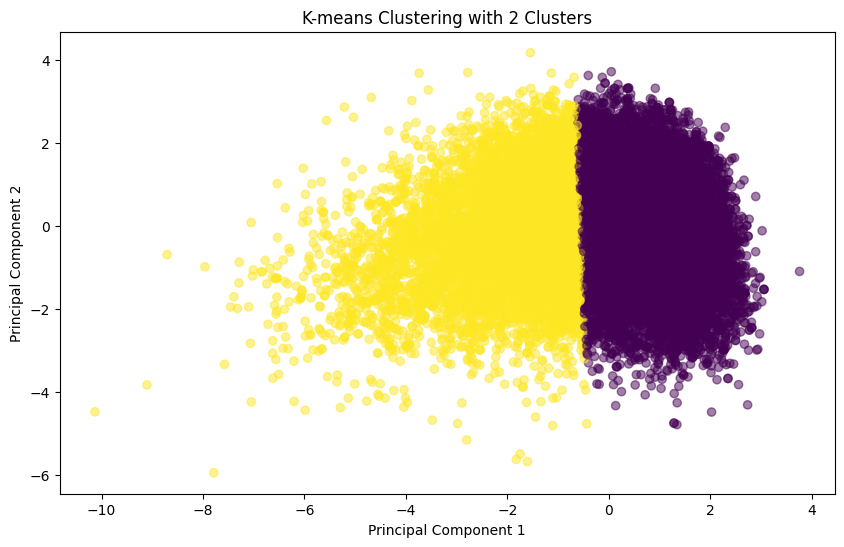

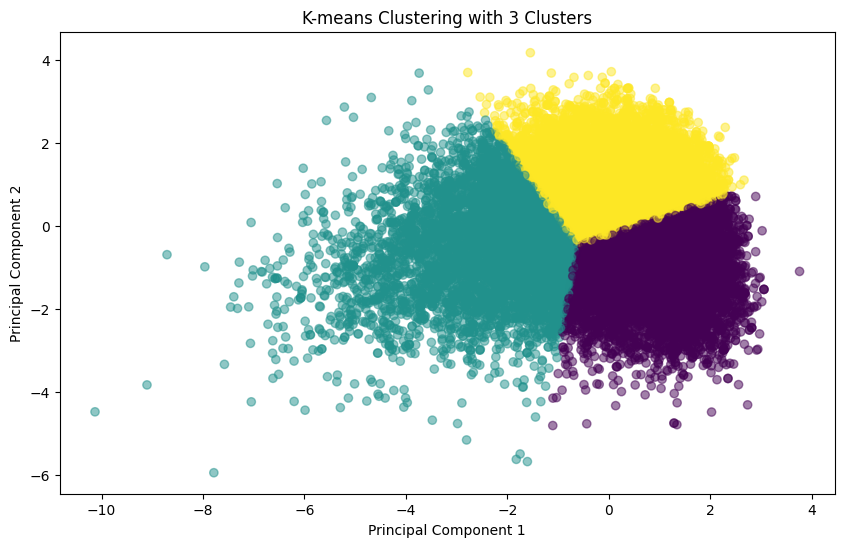

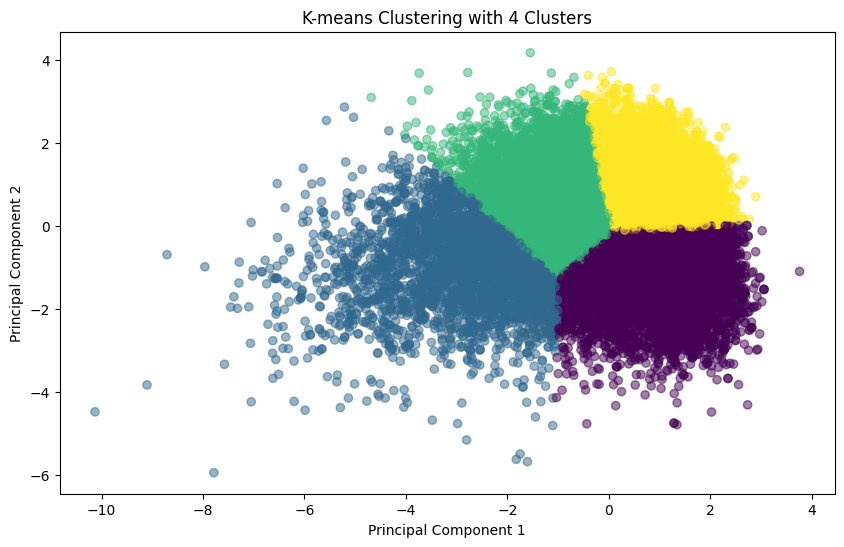

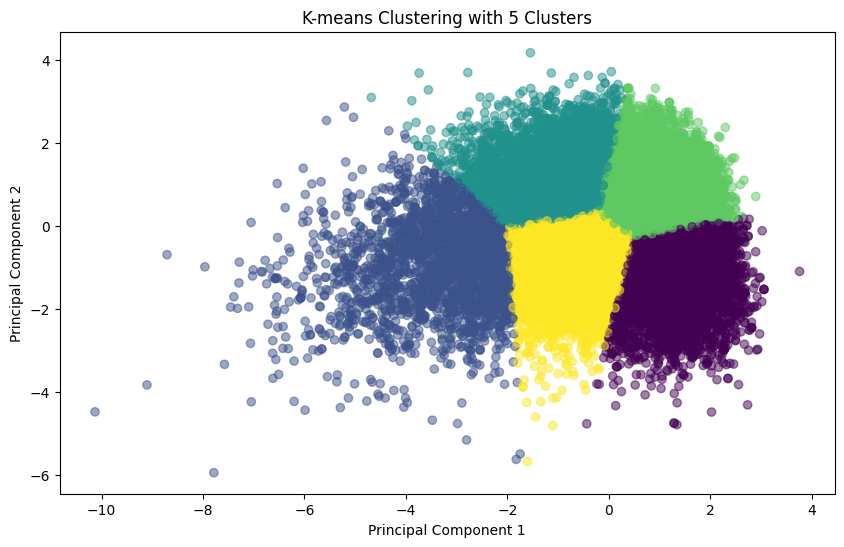

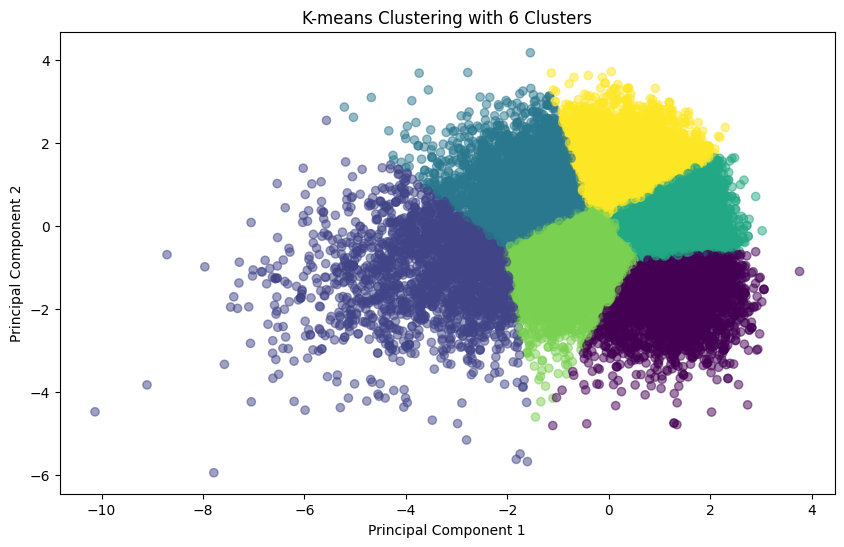

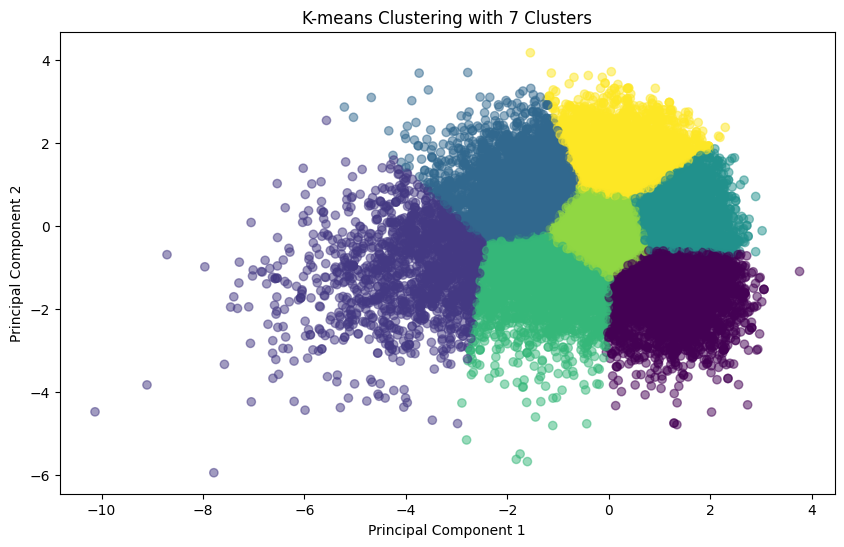

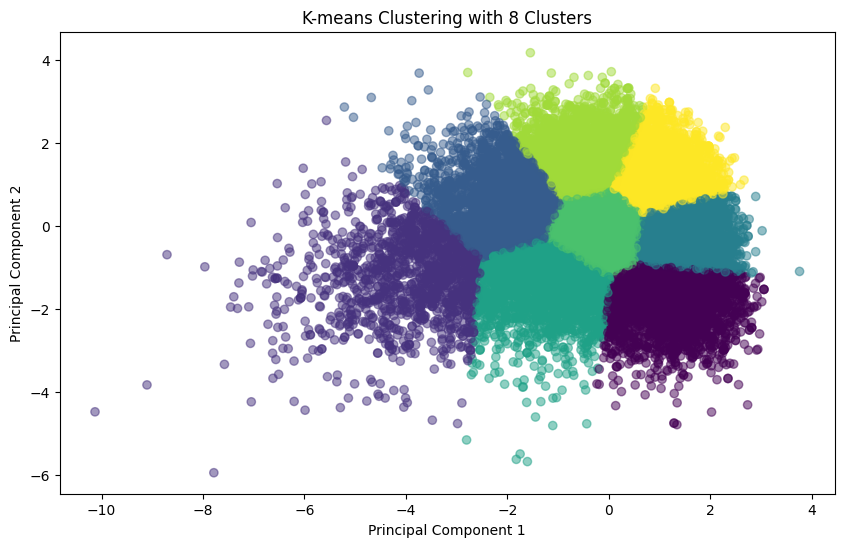

In [6]:
for n_clusters in range(2, 10):
    kmeans = KMeansFromScratch(n_clusters=n_clusters)
    kmeans.fit(spotify_pca)
    labels = kmeans.predict(spotify_pca)
    plt.figure(figsize=(10, 6))
    plt.scatter(spotify_pca[:, 0], spotify_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'K-means Clustering with {n_clusters} Clusters')
    plt.show()


The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

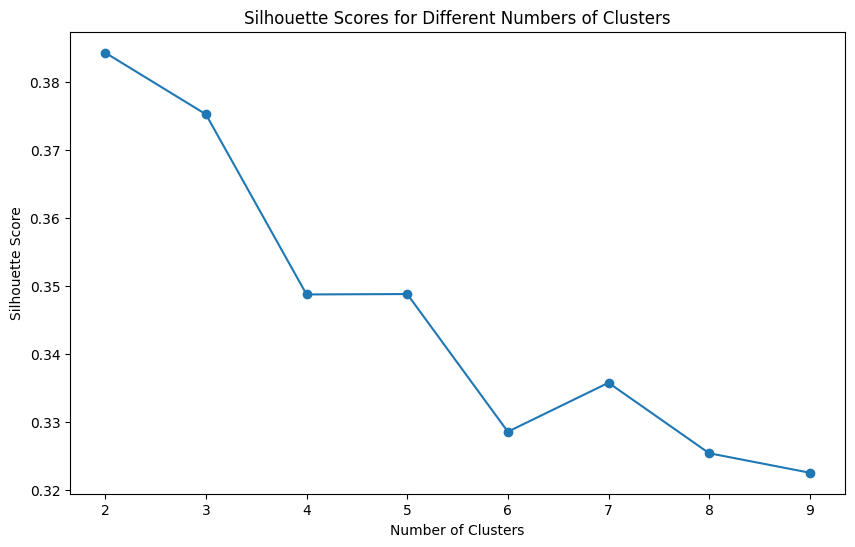

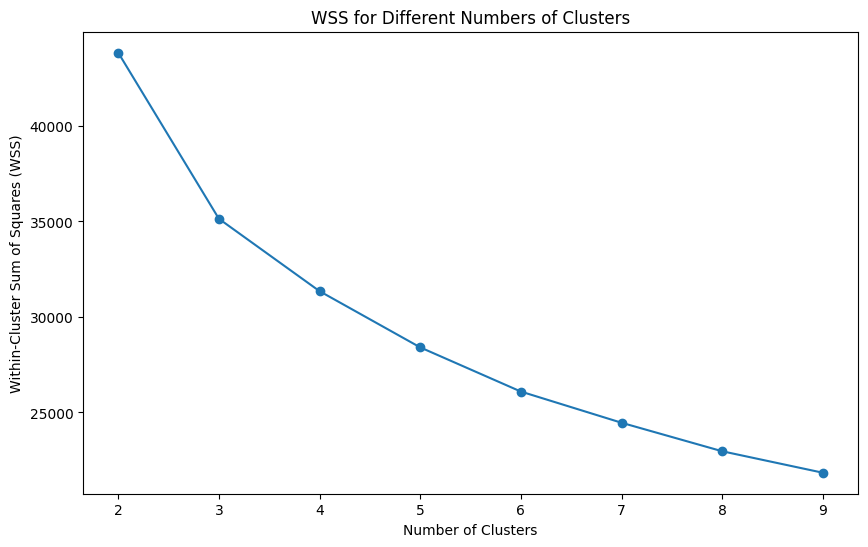

In [7]:

from sklearn.metrics import silhouette_score

silhouette_scores = []
wss_scores = []

for n_clusters in range(2, 10):
    kmeans = KMeansFromScratch(n_clusters=n_clusters)
    kmeans.fit(spotify_pca)
    labels = kmeans.predict(spotify_pca)
    silhouette_scores.append(silhouette_score(spotify_pca, labels))
    wss_scores.append(np.sum(np.min(np.linalg.norm(spotify_pca[:, np.newaxis] - kmeans.centroids, axis=2), axis=1)))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), wss_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('WSS for Different Numbers of Clusters')
plt.show()


# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

In [10]:
n_clusters = 5  
kmeans = KMeansFromScratch(n_clusters=n_clusters)
kmeans.fit(spotify_pca)
labels = kmeans.predict(spotify_pca)

for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    selected_songs = random.sample(list(cluster_indices), 2)
    print(f"Cluster {cluster}:")
    print(spotify_data.iloc[selected_songs])

Cluster 0:
                     track_id                      track_name track_artist  \
30888  0SWR0r19WhdCRFzkxBlYJW  Lightning (feat. John Rzeznik)    Cash Cash   
20385  0I6syWcqSUsZ3sXJEOIGsj                         Ráptame         Reik   

       track_popularity          track_album_id        track_album_name  \
30888                38  0KQDN58Lz8CXOsfIG6tQ7X  Blood, Sweat & 3 Years   
20385                 7  29gllJ3zBEJxU1IWkgB8Bk                 Ráptame   

      track_album_release_date                      playlist_name  \
30888               2016-06-24                          Happy EDM   
20385               2018-11-16  Latin Hip Hop & Rap Playlist 2019   

                  playlist_id playlist_genre  ... key  loudness  mode  \
30888  3d2JFEbvcx7p2CHkBaQeMZ            edm  ...   7    -3.096     0   
20385  6hIDPF658AhRbxr8HN7OeA          latin  ...   0    -6.427     1   

       speechiness  acousticness  instrumentalness  liveness  valence  \
30888       0.0495        0

Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

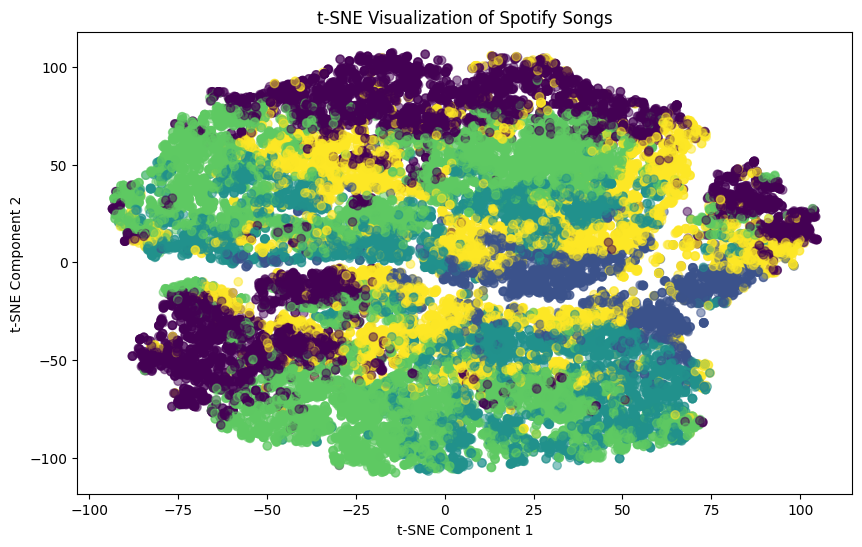

In [12]:
tsne = TSNE(n_components=2, random_state=42)
spotify_tsne = tsne.fit_transform(spotify_features_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(spotify_tsne[:, 0], spotify_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Spotify Songs')
plt.show()
